<a href="https://colab.research.google.com/github/Kabindra02/Flood_Severity_index/blob/main/flood_tcn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# IMPORTANT: SOME KAGGLE DATA SOURCES ARE PRIVATE
# RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES.
import kagglehub
kagglehub.login()


In [ ]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

kabindradhakal_flood_dataset_tcn_path = kagglehub.dataset_download('kabindradhakal/flood-dataset-tcn')

print('Data source import complete.')


In [ ]:
!pip install -U keras-tuner
!pip install keras==2.12.0
!pip install keras-tcn

  Using cached keras-2.12.0-py2.py3-none-any.whl.metadata (1.4 kB)
Using cached keras-2.12.0-py2.py3-none-any.whl (1.7 MB)
  Attempting uninstall: keras
    Found existing installation: keras 3.11.3
    Uninstalling keras-3.11.3:
      Successfully uninstalled keras-3.11.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.18.0 requires keras>=3.5.0, but you have keras 2.12.0 which is incompatible.
  Using cached keras-3.11.3-py3-none-any.whl.metadata (5.9 kB)
Using cached keras-3.11.3-py3-none-any.whl (1.4 MB)
  Attempting uninstall: keras
    Found existing installation: keras 2.12.0
    Uninstalling keras-2.12.0:
      Successfully uninstalled keras-2.12.0


In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# normalize the data
from sklearn.preprocessing import StandardScaler,MinMaxScaler

# model library

from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import SGD,RMSprop,Adam,Adadelta,Adagrad,Adamax,Nadam

# hyperparameter tuner
import keras_tuner as kt
import time
# model checkpoint
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError,MeanAbsoluteError
from tensorflow.keras.metrics import RootMeanSquaredError


# loss

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [ ]:

def load_dataset(path):
    return pd.read_csv(path)


file_path = "/kaggle/input/flood-dataset-tcn/_karnali_flood_classified_final - karnali_flood_classified.csv"
df_flood = load_dataset(file_path)


df_flood

,Date,Daily flow Rate,Gauge height flow,NDVI,sm_top_0_10cm,sm_10_40cm,24h accumulated,Daily Max Temp,Daily Min Temp,Flood_Level
0,2010-01-01,401,3.19,0.806800,12.728,41.205952,0.1,14.0,8.0,0
1,2010-01-02,397,3.18,0.805588,12.628,40.953522,1.8,14.4,10.8,0
2,2010-01-03,395,3.17,0.804375,12.533,40.707092,1.6,18.0,10.4,0
3,2010-01-04,390,3.16,0.803163,12.444,40.467663,0.0,19.5,9.5,0
4,2010-01-05,392,3.17,0.801950,12.356,40.249233,0.0,20.5,10.0,0
...,...,...,...,...,...,...,...,...,...,...
5108,2023-12-27,342,3.11,0.850400,15.803,42.957146,0.0,17.8,7.8,0
5109,2023-12-28,343,3.11,0.850400,15.623,42.818542,0.0,17.8,7.8,0
5110,2023-12-29,343,3.11,0.850400,15.421,42.648949,0.0,17.8,7.8,0
5111,2023-12-30,339,3.10,0.850400,15.228,42.470360,0.0,17.8,7.8,0


In [ ]:
features = ['Date',"Daily flow Rate","Gauge height flow","NDVI",'sm_top_0_10cm','sm_10_40cm',
           '24h accumulated','Daily Max Temp','Daily Min Temp']
df_flood = df_flood[features]


In [ ]:
df_flood

,Date,Daily flow Rate,Gauge height flow,NDVI,sm_top_0_10cm,sm_10_40cm,24h accumulated,Daily Max Temp,Daily Min Temp
0,2010-01-01,401,3.19,0.806800,12.728,41.205952,0.1,14.0,8.0
1,2010-01-02,397,3.18,0.805588,12.628,40.953522,1.8,14.4,10.8
2,2010-01-03,395,3.17,0.804375,12.533,40.707092,1.6,18.0,10.4
3,2010-01-04,390,3.16,0.803163,12.444,40.467663,0.0,19.5,9.5
4,2010-01-05,392,3.17,0.801950,12.356,40.249233,0.0,20.5,10.0
...,...,...,...,...,...,...,...,...,...
5108,2023-12-27,342,3.11,0.850400,15.803,42.957146,0.0,17.8,7.8
5109,2023-12-28,343,3.11,0.850400,15.623,42.818542,0.0,17.8,7.8
5110,2023-12-29,343,3.11,0.850400,15.421,42.648949,0.0,17.8,7.8
5111,2023-12-30,339,3.10,0.850400,15.228,42.470360,0.0,17.8,7.8


In [ ]:
import pandas as pd
import numpy as np

# data scaled

df_input = df_flood[['Daily flow Rate','Gauge height flow','NDVI','sm_top_0_10cm','sm_10_40cm',
           '24h accumulated','Daily Max Temp','Daily Min Temp']]


def min_max_scaling(data):
    # Subtract the minimum value and divide by the range
    min_val = np.min(data)
    max_val = np.max(data)
    scaled_data = (data - min_val) / (max_val - min_val)

    return scaled_data, min_val, max_val

# Assuming df_snow_melting is your DataFrame
columns_to_scale = ['Daily flow Rate','Gauge height flow','NDVI','sm_top_0_10cm','sm_10_40cm',
           '24h accumulated','Daily Max Temp','Daily Min Temp']
scaled_df = df_input.copy()

# Apply min-max scaling to specified columns
for column in columns_to_scale:
    scaled_df[column], _, _ = min_max_scaling(df_input[column])

# Print the scaled DataFrame
print(scaled_df)

      Daily flow Rate  Gauge height flow      NDVI  sm_top_0_10cm  sm_10_40cm  \
0            0.011691           0.205109  0.881291       0.110001    0.144089   
1            0.011465           0.204358  0.879842       0.106918    0.141482   
2            0.011352           0.203606  0.878392       0.103989    0.138937   
3            0.011070           0.202855  0.876943       0.101246    0.136465   
4            0.011183           0.203606  0.875493       0.098532    0.134209   
...               ...                ...       ...            ...         ...   
5108         0.008359           0.199098  0.933413       0.204803    0.162172   
5109         0.008415           0.199098  0.933413       0.199254    0.160741   
5110         0.008415           0.199098  0.933413       0.193026    0.158989   
5111         0.008189           0.198347  0.933413       0.187076    0.157145   
5112         0.008133           0.197596  0.933413       0.182082    0.155363   

      24h accumulated  Dail

In [ ]:

def df_to_X_y(df, window_size = 5):
    df_as_np = df.to_numpy()
    X = []
    y = []
    for i in range(len(df_as_np)-window_size):
        row = [r for r in df_as_np[i:i+window_size]]
        X.append(row)
        label = df_as_np[i+window_size][0]
        y.append(label)
    return np.array(X), np.array(y)

WINDOW_SIZE = 2

X, y = df_to_X_y(scaled_df,WINDOW_SIZE)

X.shape, y.shape

((5111, 2, 8), (5111,))

In [ ]:
X

array([[[1.16909522e-02, 2.05108941e-01, 8.81291094e-01, ...,
         2.00080032e-04, 1.57593123e-01, 1.84397163e-01],
        [1.14650401e-02, 2.04357626e-01, 8.79841602e-01, ...,
         3.60144058e-03, 1.69054441e-01, 2.83687943e-01]],

       [[1.14650401e-02, 2.04357626e-01, 8.79841602e-01, ...,
         3.60144058e-03, 1.69054441e-01, 2.83687943e-01],
        [1.13520840e-02, 2.03606311e-01, 8.78392110e-01, ...,
         3.20128051e-03, 2.72206304e-01, 2.69503546e-01]],

       [[1.13520840e-02, 2.03606311e-01, 8.78392110e-01, ...,
         3.20128051e-03, 2.72206304e-01, 2.69503546e-01],
        [1.10696939e-02, 2.02854996e-01, 8.76942618e-01, ...,
         0.00000000e+00, 3.15186246e-01, 2.37588652e-01]],

       ...,

       [[8.35874845e-03, 1.99098422e-01, 9.33413030e-01, ...,
         0.00000000e+00, 2.66475645e-01, 1.77304965e-01],
        [8.41522648e-03, 1.99098422e-01, 9.33413030e-01, ...,
         0.00000000e+00, 2.66475645e-01, 1.77304965e-01]],

       [[8.41522648

In [ ]:
!pip install hydroeval

In [ ]:
import hydroeval as he

In [ ]:
from tcn import TCN

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense

from tensorflow.keras.optimizers import Adam, Adamax, RMSprop, SGD
import keras_tuner as kt
from keras_tuner.tuners import RandomSearch
from tensorflow import keras

from tensorflow.keras.metrics import MeanAbsoluteError




from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from kerastuner.tuners import RandomSearch
from kerastuner.engine.hyperparameters import HyperParameters




# Define the TCN regression model
def create_tcn_regression_model(hp):
    input_layer = Input(shape=input_shape)

    # Choose the number of TCN layers
    num_tcn_layers = hp.Int('num_tcn_layers', min_value=1, max_value=3, default=2)

    tcn_layers = []
    for i in range(num_tcn_layers):
        tcn_layer = TCN(
            nb_filters=hp.Int(f'nb_filters_{i}', min_value=32, max_value=128, step=32),
            kernel_size=hp.Choice(f'kernel_size_{i}', values=[2, 3, 4]),
            dilations=[1, 2, 4, 8],
            return_sequences=True if i < num_tcn_layers - 1 else False
        )(input_layer)
        tcn_layers.append(tcn_layer)

    output_layer = Dense(1, activation='linear')(tcn_layers[-1])
    model = tf.keras.Model(inputs=input_layer, outputs=output_layer)

    # Choose an optimizer based on hyperparameter search space
    optimizer = hp.Choice('optimizer', values=['adam', 'adamax', 'rmsprop', 'sgd'])
    learning_rate = hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='log')

    if optimizer == 'adam':
        optimizer = Adam(learning_rate=learning_rate)
    elif optimizer == 'adamax':
        optimizer = Adamax(learning_rate=learning_rate,beta_1=0.9, beta_2=0.999)
    elif optimizer == 'rmsprop':
        optimizer = RMSprop(learning_rate=learning_rate)
    elif optimizer == 'sgd':
        optimizer = SGD(learning_rate=learning_rate)

    model.compile(optimizer=optimizer, loss='mean_squared_error',metrics=['mae'])

    return model



# Define the input shape based on your data
input_shape = X.shape[1:]

# Assume you have your data X and y
best_model_hyperparameters = None
best_model_mae = float('inf')

worst_model_hyperparameters = None
worst_model_mae = float('-inf')

# Assume you have your data X and y
best_model = None


# Initialize K-Fold cross-validation for the outer loop
outer_cv = KFold(n_splits=5, shuffle=True, random_state=42)

# Perform Nested Cross-Validation
nested_scores = []

for fold_outer_idx, (train_ix, test_ix) in enumerate(outer_cv.split(X)):
    X_train_outer, X_test_outer = X[train_ix], X[test_ix]
    y_train_outer, y_test_outer = y[train_ix], y[test_ix]

    # Inner loop for hyperparameter tuning
    inner_cv = KFold(n_splits=3, shuffle=True, random_state=42)
    # best_model_inner = None
    # best_score_inner = float('inf')  # Initialize with a high value

    for fold_idx, (train_ix_inner, val_ix) in enumerate(inner_cv.split(X_train_outer)):
        X_train_inner, X_val = X_train_outer[train_ix_inner], X_train_outer[val_ix]
        y_train_inner, y_val = y_train_outer[train_ix_inner], y_train_outer[val_ix]

        # Initialize Keras Tuner
        tuner = RandomSearch(
            create_tcn_regression_model,
            objective='val_loss',
            max_trials=15,
            directory=f'/content/drive/MyDrive/research/tcn/keras_tuner_random_dir_fold_tcn__new_{fold_outer_idx}_{fold_idx}',
            project_name=f'/content/drive/MyDrive/research/tcn/keras_tuner_random_dir_fold_tcn_new_{fold_outer_idx}_{fold_idx}/hyperparameter_random_tuning_fold_tcn_{fold_outer_idx}_{fold_idx}'
        )

        # Search for the best hyperparameters
        tuner.search(X_train_inner, y_train_inner, validation_data=(X_val, y_val), epochs=10)

        best_hps = tuner.oracle.get_best_trials(1)[0].hyperparameters
        print(f"Best hyperparameters for fold {fold_idx}: {best_hps}")

        model = create_tcn_regression_model(best_hps)
        es = EarlyStopping(patience=10, restore_best_weights=True)

        model.fit(
            X_train_inner,
            y_train_inner,
            validation_data=(X_val, y_val),
            epochs=100,
            batch_size=32,
            callbacks=[es],
        )

        y_pred = model.predict(X_val)
        mae = mean_absolute_error(y_val, y_pred)

        # Update best model
        if mae < best_model_mae:
            best_model_mae = mae
            best_model_hyperparameters = best_hps
            best_model = model

        # Update worst model
        if mae > worst_model_mae:
            worst_model_mae = mae
            worst_model_hyperparameters = best_hps
            worst_model = model

    # Now that we have the best model, evaluate it on the test set
        # Now that we have the best and worst models, evaluate them on the test set
    start_time = time.time()
    y_pred_best = best_model.predict(X_test_outer)
    end_time = time.time()
    y_pred_worst = worst_model.predict(X_test_outer)

    mse_best = mean_squared_error(y_test_outer, y_pred_best)
    mae_best = mean_absolute_error(y_test_outer, y_pred_best)
    rmse_best = np.sqrt(mse_best)

    nse_best = he.evaluator(he.nse, y_pred_best, y_test_outer)
    kge_best = he.evaluator(he.kge, y_pred_best, y_test_outer)
    print("Best Model:")
    print("KGE : ", kge_best)

    r2_best = r2_score(y_test_outer, y_pred_best)
    time_duration = end_time - start_time

    mse_worst = mean_squared_error(y_test_outer, y_pred_worst)
    mae_worst = mean_absolute_error(y_test_outer, y_pred_worst)
    rmse_worst = np.sqrt(mse_worst)

    nse_worst = he.evaluator(he.nse, y_pred_worst, y_test_outer)
    kge_worst, r, alpha, beta = he.evaluator(he.kge, y_pred_worst, y_test_outer)
    print("Worst Model:")
    print("KGE : ", kge_worst)

    r2_worst = r2_score(y_test_outer, y_pred_worst)
    time_duration = end_time - start_time

    nested_scores.append({
        "Best Model": {
            "MSE": mse_best,
            "R^2": r2_best,
            "RMSE": rmse_best,
            "MAE": mae_best,
            "testing time": time_duration,
            "nse": nse_best,
            "kge": kge_best
        },
        "Worst Model": {
            "MSE": mse_worst,
            "R^2": r2_worst,
            "RMSE": rmse_worst,
            "MAE": mae_worst,
            "testing time": time_duration,
            "nse": nse_worst,
            "kge": kge_worst
        }
    })

# Save the best and worst hyperparameters
print("Best Hyperparameters:", best_model_hyperparameters)
print("Best MAE:", best_model_mae)

print("Worst Hyperparameters:", worst_model_hyperparameters)
print("Worst MAE:", worst_model_mae)

Trial 15 Complete [00h 00m 20s]
val_loss: 0.0022958742920309305

Best val_loss So Far: 0.0011358455521985888
Total elapsed time: 00h 05m 31s
Best hyperparameters for fold 2: <keras_tuner.src.engine.hyperparameters.hyperparameters.HyperParameters object at 0x7b3dd194c110>
Epoch 1/100
86/86 ━━━━━━━━━━━━━━━━━━━━ 8s 17ms/step - loss: 0.0104 - mae: 0.0577 - val_loss: 0.0016 - val_mae: 0.0213
Epoch 2/100
86/86 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 5.4948e-04 - mae: 0.0149 - val_loss: 0.0013 - val_mae: 0.0145
Epoch 3/100
86/86 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 4.6150e-04 - mae: 0.0134 - val_loss: 0.0014 - val_mae: 0.0176
Epoch 4/100
86/86 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 4.0858e-04 - mae: 0.0125 - val_loss: 0.0013 - val_mae: 0.0122
Epoch 5/100
86/86 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 3.8747e-04 - mae: 0.0120 - val_loss: 0.0013 - val_mae: 0.0155
Epoch 6/100
86/86 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 4.2329e-04 - mae: 0.0132 - val_loss: 0.0013 - val_mae: 0.0124
Epoch

In [ ]:
print("Nested Cross-Validation Scores:")
for i, scores in enumerate(nested_scores):
    print(f"\nFold {i + 1} - MSE: {scores['Best Model']['MSE']}, R^2: {scores['Best Model']['R^2']}, RMSE: {scores['Best Model']['RMSE']}, MAE: {scores['Best Model']['MAE']}, kge: {scores['Best Model']['kge']}, nse: {scores['Best Model']['nse']}, time: {scores['Best Model']['testing time']}")

Nested Cross-Validation Scores:

Fold 1 - MSE: 0.0009614164805490593, R^2: 0.8660333739920636, RMSE: 0.031006716700564402, MAE: 0.009904298158849913, kge: [[0.91619989]
 [0.93089885]
 [0.95331728]
 [1.00825916]], nse: [0.86603337], time: 0.27416181564331055

Fold 2 - MSE: 0.00021689247379108188, R^2: 0.9625903275544787, RMSE: 0.01472726973308637, MAE: 0.007362718837457378, kge: [[0.96832903]
 [0.9814812 ]
 [0.99913758]
 [1.02567802]], nse: [0.96259033], time: 0.24918651580810547

Fold 3 - MSE: 0.0002895484634183574, R^2: 0.9533221012528905, RMSE: 0.01701612363079081, MAE: 0.008292249970315973, kge: [[0.96112415]
 [0.9769989 ]
 [1.00241017]
 [1.03124855]], nse: [0.9533221], time: 0.2740769386291504

Fold 4 - MSE: 0.0009098182888612414, R^2: 0.8764210111750044, RMSE: 0.030163194274831728, MAE: 0.009297113859313554, kge: [[0.88748989]
 [0.93667431]
 [0.90813494]
 [0.98553652]], nse: [0.87642101], time: 0.41724610328674316

Fold 5 - MSE: 0.0008234207290946403, R^2: 0.8866540975747942, RMSE

In [ ]:
# Calculate overall statistics
all_mse = [scores['Best Model']['MSE'] for scores in nested_scores]
all_mae = [scores['Best Model']['MAE'] for scores in nested_scores]
all_rsme = [scores['Best Model']['RMSE'] for scores in nested_scores]
all_r2 = [scores['Best Model']['R^2'] for scores in nested_scores]
all_kge = [scores['Best Model']['kge'] for scores in nested_scores]
all_nse = [scores['Best Model']['nse'] for scores in nested_scores]
all_time = [scores['Best Model']['testing time'] for scores in nested_scores]
mean_mse = np.mean(all_mse)
mean_mae = np.mean(all_mae)
mean_rsme = np.mean(all_rsme)
mean_r2 = np.mean(all_r2)
mean_kge = np.mean(all_kge)
mean_nse = np.mean(all_nse)
mean_time = np.mean(all_time)

print(f"Mean MSE: {mean_mse:.3f}")
print(f"Mean MAE: {mean_mae:.3f}")
print(f"Mean RMSE: {mean_rsme:.3f}")
print(f"Mean R^2: {mean_r2:.3f}")
print(f"Mean kge: {mean_kge:.3f}")
print(f"Mean nse: {mean_nse:.3f}")
print(f"Mean time: {mean_time:.3f}")

Mean MSE: 0.001
Mean MAE: 0.009
Mean RMSE: 0.024
Mean R^2: 0.909
Mean kge: 0.959
Mean nse: 0.909
Mean time: 0.325


In [ ]:
pip install keras-tcn

Note: you may need to restart the kernel to use updated packages.


In [ ]:
from tcn import TCN, tcn_full_summary
from tcn.tcn import ResidualBlock

160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


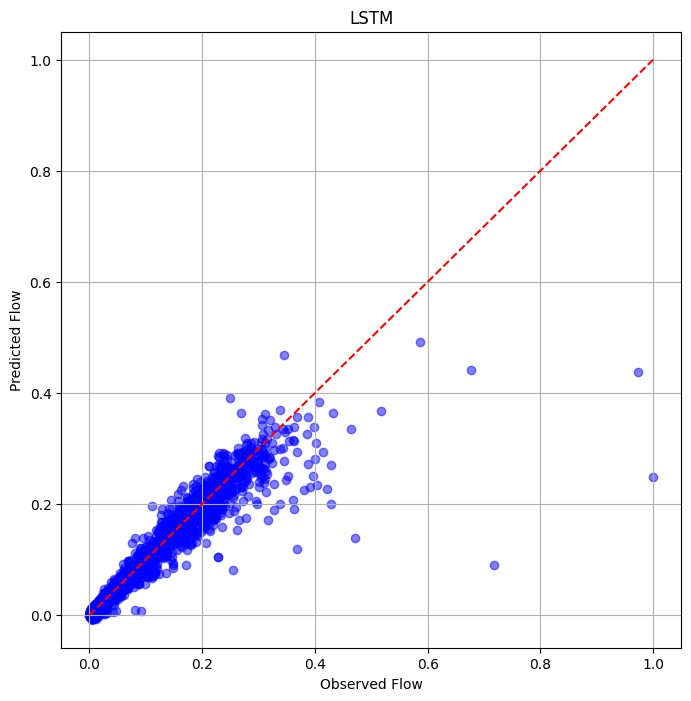

In [ ]:
import matplotlib.pyplot as plt

# Assuming you have arrays y_pred and y_observed
# y_pred and y_observed should have the same length
y_pred = best_model.predict(X).flatten()
y_observed = y
plt.figure(figsize=(8, 8))
plt.scatter(y_observed, y_pred, color='blue', alpha=0.5)
plt.plot([min(y_observed), max(y_observed)], [min(y_observed), max(y_observed)], color='red', linestyle='--')
plt.title('LSTM')
plt.xlabel('Observed Flow')
plt.ylabel('Predicted Flow')
plt.grid(True)
plt.show()

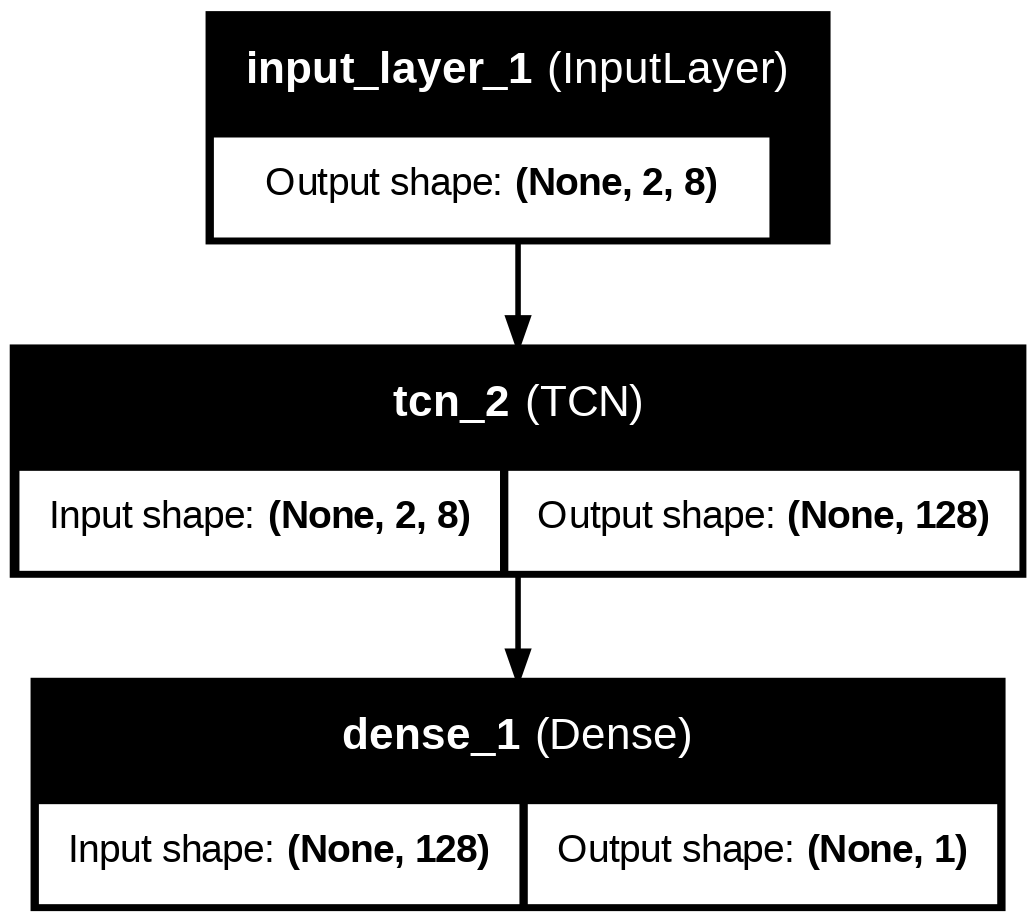

In [ ]:
from keras.utils import plot_model
# Visualize the model architecture and save the diagram to a file
plot_model(best_model, to_file='tcn_model.png', show_shapes=True, show_layer_names=True)

In [ ]:
optimizer = best_model.optimizer
learning_rate = float(optimizer.learning_rate.numpy())

# Print the optimizer and learning rate
print("Optimizer:", type(optimizer).__name__)
print("Learning Rate:", learning_rate)

Optimizer: RMSprop
Learning Rate: 0.0020920762326568365


In [ ]:
print("Nested Cross-Validation Scores:")
for i, scores in enumerate(nested_scores):
    print(f"\nFold {i + 1} - MSE: {scores['Best Model']['MSE']}, R^2: {scores['Best Model']['R^2']}, RMSE: {scores['Best Model']['RMSE']}, MAE: {scores['Best Model']['MAE']}, kge: {scores['Best Model']['kge']}, nse: {scores['Best Model']['nse']}, time: {scores['Best Model']['testing time']}")


Nested Cross-Validation Scores:

Fold 1 - MSE: 0.0009614164805490593, R^2: 0.8660333739920636, RMSE: 0.031006716700564402, MAE: 0.009904298158849913, kge: [[0.91619989]
 [0.93089885]
 [0.95331728]
 [1.00825916]], nse: [0.86603337], time: 0.27416181564331055

Fold 2 - MSE: 0.00021689247379108188, R^2: 0.9625903275544787, RMSE: 0.01472726973308637, MAE: 0.007362718837457378, kge: [[0.96832903]
 [0.9814812 ]
 [0.99913758]
 [1.02567802]], nse: [0.96259033], time: 0.24918651580810547

Fold 3 - MSE: 0.0002895484634183574, R^2: 0.9533221012528905, RMSE: 0.01701612363079081, MAE: 0.008292249970315973, kge: [[0.96112415]
 [0.9769989 ]
 [1.00241017]
 [1.03124855]], nse: [0.9533221], time: 0.2740769386291504

Fold 4 - MSE: 0.0009098182888612414, R^2: 0.8764210111750044, RMSE: 0.030163194274831728, MAE: 0.009297113859313554, kge: [[0.88748989]
 [0.93667431]
 [0.90813494]
 [0.98553652]], nse: [0.87642101], time: 0.41724610328674316

Fold 5 - MSE: 0.0008234207290946403, R^2: 0.8866540975747942, RMSE

In [ ]:
# Calculate overall statistics
all_mse = [scores['Best Model']['MSE'] for scores in nested_scores]
all_mae = [scores['Best Model']['MAE'] for scores in nested_scores]
all_rsme = [scores['Best Model']['RMSE'] for scores in nested_scores]
all_r2 = [scores['Best Model']['R^2'] for scores in nested_scores]
all_kge = [scores['Best Model']['kge'] for scores in nested_scores]
all_nse = [scores['Best Model']['nse'] for scores in nested_scores]
all_time = [scores['Best Model']['testing time'] for scores in nested_scores]
mean_mse = np.mean(all_mse)
mean_mae = np.mean(all_mae)
mean_rsme = np.mean(all_rsme)
mean_r2 = np.mean(all_r2)
mean_kge = np.mean(all_kge)
mean_nse = np.mean(all_nse)
mean_time = np.mean(all_time)

print(f"Mean MSE: {mean_mse:.3f}")
print(f"Mean MAE: {mean_mae:.3f}")
print(f"Mean RMSE: {mean_rsme:.3f}")
print(f"Mean R^2: {mean_r2:.3f}")
print(f"Mean kge: {mean_kge:.3f}")
print(f"Mean nse: {mean_nse:.3f}")
print(f"Mean time: {mean_time:.3f}")


Mean MSE: 0.001
Mean MAE: 0.009
Mean RMSE: 0.024
Mean R^2: 0.909
Mean kge: 0.959
Mean nse: 0.909
Mean time: 0.325


160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


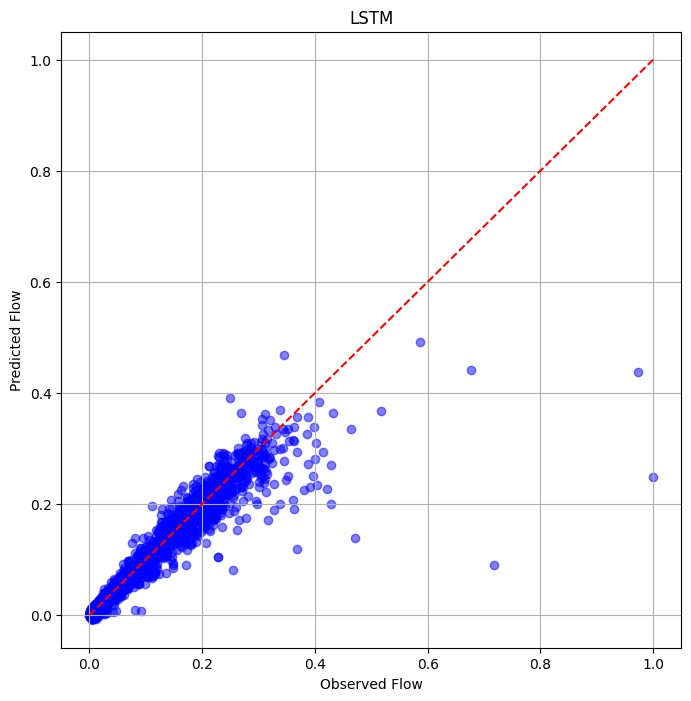

In [ ]:
import matplotlib.pyplot as plt

# Assuming you have arrays y_pred and y_observed
# y_pred and y_observed should have the same length
y_pred = best_model.predict(X).flatten()
y_observed = y
plt.figure(figsize=(8, 8))
plt.scatter(y_observed, y_pred, color='blue', alpha=0.5)
plt.plot([min(y_observed), max(y_observed)], [min(y_observed), max(y_observed)], color='red', linestyle='--')
plt.title('LSTM')
plt.xlabel('Observed Flow')
plt.ylabel('Predicted Flow')
plt.grid(True)
plt.show()


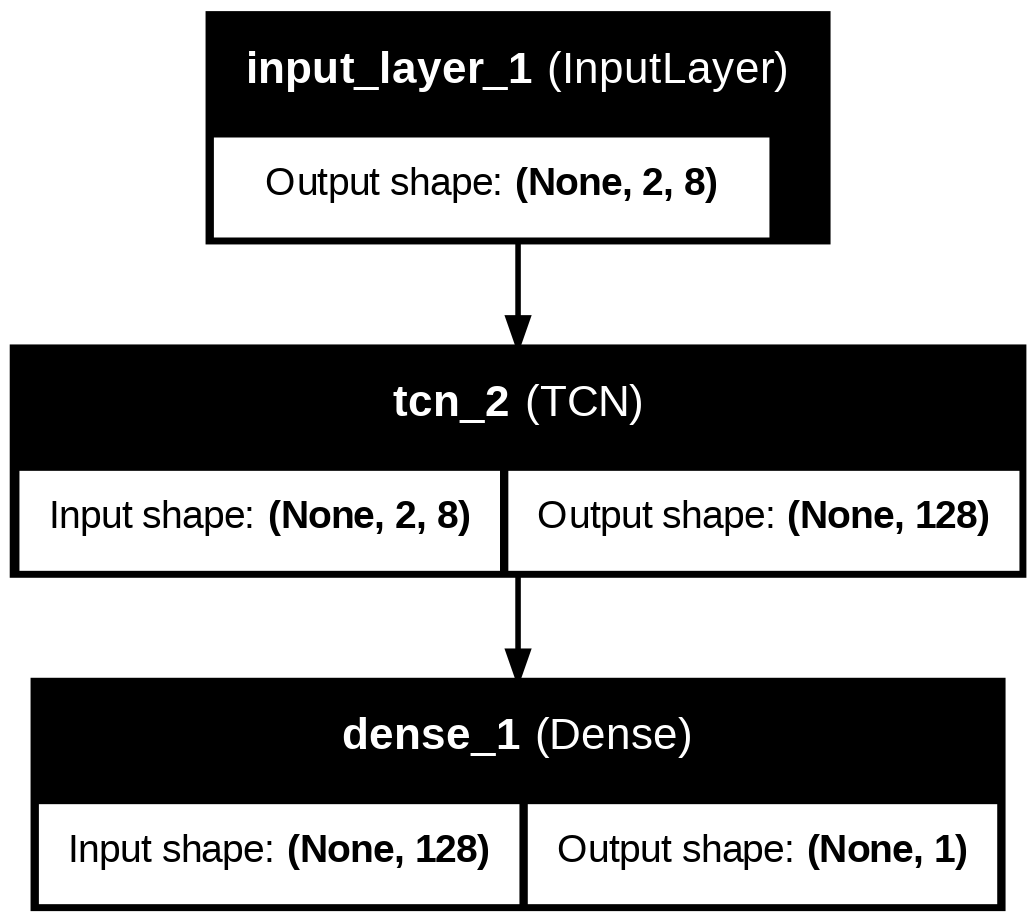

In [ ]:
from keras.utils import plot_model
# Visualize the model architecture and save the diagram to a file
plot_model(best_model, to_file='tcn_model.png', show_shapes=True, show_layer_names=True)

In [ ]:
optimizer = best_model.optimizer
learning_rate = float(optimizer.learning_rate.numpy())

# Print the optimizer and learning rate
print("Optimizer:", type(optimizer).__name__)
print("Learning Rate:", learning_rate)


Optimizer: RMSprop
Learning Rate: 0.0020920762326568365


In [ ]:
# Function to extract dropout rate from a layer
def get_dropout_rate(layer):
    if hasattr(layer, 'rate'):
        return layer.rate
    elif hasattr(layer, 'dropout'):
        return layer.dropout
    else:
        return None

# Iterate through layers of the model and find the dropout rates
dropout_rates = []

for layer in best_model.layers:
    rate = get_dropout_rate(layer)
    if rate is not None:
        dropout_rates.append((layer.name, rate))

# Print the dropout rates
print("Dropout Rates:")
for layer_name, rate in dropout_rates:
    print(f"{layer_name}: {rate}")

Dropout Rates:


In [ ]:
from keras.models import load_model
import tensorflow as tf

# Load the saved model with custom_objects
loaded_model = load_model('/kaggle/working/best_model.keras', custom_objects={'TCN': TCN})


In [ ]:

loaded_model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 2, 8)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ tcn_3 (TCN)                     │ (None, 32)             │        22,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 68,549 (267.77 KB)

 Trainable params: 22,849 (89.25 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 45,700 (178.52 KB)

In [ ]:
model.save('best_model.keras')


In [ ]:
# Extract hyperparameters
num_tcn_layers = sum(1 for layer in loaded_model.layers if isinstance(layer, TCN))
num_filters = loaded_model.get_config()['layers'][0]['config']# Adjust the layer index accordingly
kernel_size = loaded_model.get_config()['layers'][0]['config'] # Adjust the layer index accordingly
# Add other hyperparameters as needed

# Print hyperparameters
print("Number of TCN Layers:", num_tcn_layers)
print("Number of Filters:", num_filters)
print("Kernel Size:", kernel_size)

Number of TCN Layers: 1
Number of Filters: {'batch_shape': (None, 2, 8), 'dtype': 'float32', 'sparse': False, 'ragged': False, 'name': 'input_layer_1'}
Kernel Size: {'batch_shape': (None, 2, 8), 'dtype': 'float32', 'sparse': False, 'ragged': False, 'name': 'input_layer_1'}
